# The Battle of Neighborhoods 
for the Applied Data Science Capstone Project

# Introduction / The business problem

The current study will try to provide an optimum location for __opening a new business in a Toronto city__, based on: 

•	A neighborhoods property, e.g. the second most common language spoken (after English) in the neighborhood,

•	The number of competitors in the neighborhood, 

•	The population density in the neighborhood.   


Let's investigate in Toronto, and propose the best possible place for opening a new restaurant with ethnic cuisine. Assume that preferably we would like the new restaurant to be located in a neighborhood with a high degree of the same ethnic characteristics, i.e. assume the languages spoken in that neighborhood, so to make advantage of the cultural element of the area. In order to sustain the new business, there should be a lot of population and the less number of competitors possible.

__TARGET AUDIENCE__ The results could be highly usable for people having ethnic cooking skills or restaurant-businessmen, and want to open an ethnic restaurant in a neighborhood having some degree of the same ethnic culture in Toronto.



# Data Description

The datasets that will be used are for retrieving information about city's neighborhoods and their characteristics are taken from Wikipedia website for the Toronto demographic information:

•	https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods

The geographic coordinates of the neighborhoods of Old Toronto are taken from:

•	File 'oldToronto.csv' which the latitude and longitude per neighborhood in Old Toronto area.

Combining the above data sets, we get demographic information, focused on Old Toronto's neighborhoods and the exact coordinates per neighborhood. Then by using the __Foursquare API__, we can retrieve further information for venues, venue categories and venue coordinates for every area. The Foursquare data set combined with the neighborhood's data set with demographic information will be the main data set that we will be used for the analysis. Visualization of the results via maps and graphs, where possible, will help to explain the data.

Based on the language spoken (second language spoken after 'English'), the neighborhood's population and the number of ethnic restaurants (restaurants with ethnicity common with the language spoken) in a neighborhood the best possible set of candidate neighborhoods can be retrieved. Then by using k-means algorithm the candidate neighborhoods will be further analyzed. The final results, via tables and maps will conclude on finding the best neighborhood to start an ethnic restaurant in an ethnic-cultural neighborhood, show any existing patterns and similarities between ethnic restaurants and ethnic populated neighborhoods in Old Toronto area.



### Importing Required Libraries

In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

#!pip install msgpack
import msgpack

#!pip install BeautifulSoup4
from bs4 import BeautifulSoup

#import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
from folium.plugins import MarkerCluster

#!pip install geocoder
import geocoder # import geocoder

from IPython.display import display

# Save to demographic.csv  (wikipedia information)
# Read from oldToronto.csv (coordingates per neighborhood)
# Read from Toronto_choropleth_coordinates.json
# Save to 'Toronto.csv' (megring of oldToronto and demographic)
# Save the feedback from foursquare for radius=1000m, limit=100

# Save the summary dataframe
#Toronto_restaurants_conclude.to_csv('Toronto_restaurants_conclude.csv')

# Save the dataframe with the competitors
#Toronto_competitors_coord.to_csv('Toronto_competitors_coord')


In [5]:
# Use the link from wikipedia with BeatifulSoup to retrieve the demographic data
demographic_link =  'https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'

source = requests.get(demographic_link).text
soup = BeautifulSoup(source, 'lxml')

wiki_table = soup.find('table', class_='wikitable sortable')

In [6]:
# Data scraping

headers = []
for th in wiki_table.find_all('th'):
    headers.append(th.text)

data = []
for td in wiki_table.find_all('td'):
    data.append(td.text)

Neighborhood = []
for nb in range (13,len(data),13):
    Neighborhood.append(data[nb])

Population = []
for pop in range (16,len(data),13):
    Population.append(data[pop])

Density = []
for den in range (18,len(data),13):
    Density.append(data[den])

Average_income = []
for income in range (20,len(data),13):
    Average_income.append(data[income])

# Clear data
#'45,792Canada 2011 Census[1]\n'
x,y = Average_income[63].split('Canada')
Average_income[63] = x
Average_income[63]
Average_income

Second_language_percentage = []
Second_language_name = []

for language in range (24,len(data),13):
    num, name = data[language].split('%')
    Second_language_percentage.append(num)
    Second_language_name.append(name)    
#Second_language_percentage, Second_language_name

# Create the dataframe for the chosen columns from wiki link
# Further clearing the data and transform to the correct data types, e.g. int/float,etc.
# Save the file to'demographic.csv'

d1 = {'Neighborhood': Neighborhood, 
      'Population': Population, 
      'Density':Density, 
      'Average income':Average_income,
      'Second language after English, %':Second_language_percentage,
      'Second language after English, name':Second_language_name
     }

demographic = pd.DataFrame(d1)
demographic.replace(r'\n', '', regex = True, inplace = True)
demographic.replace(',', '', regex = True, inplace = True)
demographic['Second language after English, name'] = demographic['Second language after English, name'].str.lstrip()
demographic['Population'] = demographic['Population'].astype(int)
demographic['Density'] = demographic['Density'].astype(int)
demographic['Average income'] = demographic['Average income'].astype(int)
demographic['Second language after English, %'] = demographic['Second language after English, %'].astype(float)

# Create new column with the population speaking second language after English
demographic['Second language population'] = (demographic['Population'] * (demographic['Second language after English, %'] / 100)).astype(int)

# Assume Unspecified Chinese as Chinese
demographic['Second language after English, name'] = demographic['Second language after English, name'].str.replace('Unspecified Chinese', 'Chinese' )

# Remove 'Toronto island' since it has 'any' as language (undetermined ethnicity)
demographic = demographic[demographic['Neighborhood'] !='Toronto Islands']

demographic
# Check the data types again
#demographic.dtypes

# Save to a file
demographic.to_csv('demographic.csv')
demographic.head(10)

,Neighborhood,Population,Density,Average income,"Second language after English, %","Second language after English, name",Second language population
0,Agincourt,44577,3580,25750,19.3,Cantonese,8603
1,Alderwood,11656,2360,35239,6.2,Polish,722
2,Alexandra Park,4355,13609,19687,17.9,Cantonese,779
3,Allenby,2513,4333,245592,1.4,Russian,35
4,Amesbury,17318,4934,27546,6.1,Spanish,1056
5,Armour Heights,4384,1914,116651,9.4,Russian,412
6,Banbury,6641,2442,92319,5.1,Chinese,338
7,Bathurst Manor,14945,3187,34169,9.5,Russian,1419
8,Bay Street Corridor,4787,43518,40598,9.6,Mandarin,459
9,Bayview Village,12280,2966,46752,8.4,Cantonese,1031


In [7]:
# Read the coordinates per neighborhood, focused only in oldToronto
oldToronto = pd.read_csv('oldToronto.csv')
oldToronto

# Merge the two dataframes in order to get the coordinates for neighborhoods from old city of Toronto only
Toronto = pd.merge(demographic, oldToronto, on='Neighborhood', how='inner')
Toronto.rename(index=str, columns={"Second language after English, %": "Percentage", "Second language after English, name": "Language"}, inplace=True)

# Save the file (Toronto.csv)
Toronto.to_csv('Toronto.csv')
Toronto.head(10)

,Neighborhood,Population,Density,Average income,Percentage,Language,Second language population,Latitude,Longitude
0,Alexandra Park,4355,13609,19687,17.9,Cantonese,779,43.71627,-79.40555
1,Allenby,2513,4333,245592,1.4,Russian,35,43.71275,-79.54746
2,Bay Street Corridor,4787,43518,40598,9.6,Mandarin,459,43.65777,-79.38619
3,Bedford Park,13749,6057,80827,0.7,Greek,96,43.73138,-79.42116
4,Bloor West Village,5175,6993,55578,3.6,Ukrainian,186,43.65936,-79.48543
5,Bracondale Hill,5343,8618,41605,4.8,Greek,256,43.67600,-79.42803
6,Brockton,9039,8217,27260,19.9,Portuguese,1798,43.66055,-79.40531
7,Cabbagetown,11120,7943,50398,1.6,Chinese,177,43.66763,-79.36606
8,Carleton Village,6544,8843,23301,17.0,Portuguese,1112,43.67200,-79.45700
9,Casa Loma,3597,5369,82203,1.8,Korean,64,43.67000,-79.41000


In [54]:
# Create map of Toronto using latitude and longitude values,
# where the neighborhoods of Old Toronto are shown, and the most common language after English in that area.

map_Toronto_neighborhoods = folium.Map(location=[43.653963, -79.387207], zoom_start=14, tiles = "Stamen Toner")

# Use different colors for each language
clrs =['red', 'blue', 'green', 'purple', 'orange', 'pink', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
       'darkpurple', 'cyan', 'yellow', 'lightblue', 'lightgreen','gray', 'black']

lang = Toronto['Language'].unique()

CLR = dict(zip(lang,clrs))

# add markers to map
for lat, lng, nb, lang, perc in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Neighborhood'],Toronto['Language'],Toronto['Percentage']):
    folium.Marker(
        location=[lat,lng],
        popup='{} ({}% {})'.format(nb,perc,lang),
        icon=folium.Icon(CLR[lang])).add_to(map_Toronto_neighborhoods) 
    
map_Toronto_neighborhoods

In [9]:
# @hidden_cell

# Foursquare credentials for using the API
CLIENT_ID = '************************************' # your Foursquare ID
CLIENT_SECRET = '*********************************' # your Foursquare Secret
VERSION = '20190304' # Foursquare API version

# Use radius 1000 from neighborhood centers and limit to 100 venues.
radius = 1000
LIMIT = 100

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    x = 0
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(x, name)
        x = x+1    
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
# Identify all the venues per neighborhood in Old Toronto's neighborhoods
Toronto_venues = getNearbyVenues(names=Toronto['Neighborhood'],
                                   latitudes=Toronto['Latitude'],
                                   longitudes=Toronto['Longitude'])

#Save the feedback from foursquare for radius=1000m, limit=100
Toronto_venues.to_csv('Toronto_venues.csv')

0 Alexandra Park
1 Allenby
2 Bay Street Corridor
3 Bedford Park
4 Bloor West Village
5 Bracondale Hill
6 Brockton
7 Cabbagetown
8 Carleton Village
9 Casa Loma
10 Chaplin Estates
11 Christie Pits
12 Church and Wellesley
13 Corktown
14 Davenport
15 Davisville
16 Deer Park
17 Discovery District
18 Distillery District/West Don Lands
19 Dovercourt Park
20 Dufferin Grove
21 Earlscourt
22 East Danforth
23 Fashion District
24 Financial District
25 Forest Hill
26 Fort York/Liberty Village
27 Garden District
28 Grange Park
29 Harbord Village
30 Harbourfront / CityPlace
31 High Park North
32 Junction Triangle
33 Kensington Market
34 Lawrence Park
35 Leslieville
36 Little Italy
37 Little Portugal
38 Lytton Park
39 Moore Park
40 Niagara
41 Parkdale
42 Playter Estates
43 Port Lands
44 Regal Heights
45 Regent Park/Trefann Court
46 Riverdale
47 Roncesvalles
48 Rosedale
49 Seaton Village
50 South Hill
51 St. James Town
52 Summerhill
53 Swansea
54 The Annex
55 The Beaches
56 The Danforth
57 The Junction

In [12]:
# Read from 'Toronto_venues.csv'
#Toronto_venues = pd.read_csv('Toronto_venues.csv')
Toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alexandra Park,43.71627,-79.40555,Sheridan Nurseries,43.719005,-79.400500,Flower Shop
1,Alexandra Park,43.71627,-79.40555,Himalayan Java,43.713486,-79.399811,Café
2,Alexandra Park,43.71627,-79.40555,De Mello Palheta Coffee Roasters,43.711791,-79.399403,Coffee Shop
3,Alexandra Park,43.71627,-79.40555,Uncle Betty's Diner,43.714452,-79.400091,Diner
4,Alexandra Park,43.71627,-79.40555,Douce France,43.711554,-79.399394,Bakery
5,Alexandra Park,43.71627,-79.40555,Starbucks,43.711200,-79.399182,Coffee Shop
6,Alexandra Park,43.71627,-79.40555,Alexander Muir Memorial Gardens,43.721315,-79.400822,Garden
7,Alexandra Park,43.71627,-79.40555,Barreworks,43.714070,-79.400109,Yoga Studio
8,Alexandra Park,43.71627,-79.40555,Cibo Wine Bar,43.711464,-79.399570,Italian Restaurant
9,Alexandra Park,43.71627,-79.40555,La Vecchia Ristorante,43.710167,-79.399086,Italian Restaurant


In [13]:
# Keep only the venues that are 'Restaurants'
target_category = 'Restaurant'
Toronto_restaurants_coord = (Toronto_venues[(Toronto_venues['Venue Category'].str.contains(target_category))]).reset_index(drop=True)
Toronto_restaurants_coord.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alexandra Park,43.71627,-79.40555,Cibo Wine Bar,43.711464,-79.399570,Italian Restaurant
1,Alexandra Park,43.71627,-79.40555,La Vecchia Ristorante,43.710167,-79.399086,Italian Restaurant
2,Alexandra Park,43.71627,-79.40555,Grazie Ristorante,43.709329,-79.398823,Italian Restaurant
3,Alexandra Park,43.71627,-79.40555,Tio's Urban Mexican,43.714630,-79.400000,Mexican Restaurant
4,Alexandra Park,43.71627,-79.40555,Sushi Shop,43.713609,-79.399844,Restaurant
5,Alexandra Park,43.71627,-79.40555,Banh Mi Boys,43.709217,-79.398777,Fast Food Restaurant
6,Alexandra Park,43.71627,-79.40555,Sushi Rock Café,43.709089,-79.398641,Sushi Restaurant
7,Alexandra Park,43.71627,-79.40555,Mai Thai Restaurant,43.708779,-79.398720,Thai Restaurant
8,Allenby,43.71275,-79.54746,Faley Restaurant,43.713817,-79.558676,Asian Restaurant
9,Allenby,43.71275,-79.54746,Mcdonald's in Walmart,43.714250,-79.553289,Fast Food Restaurant


In [14]:
# Total number of restaurants per neighborhood
Toronto_num_of_restaurants = Toronto_restaurants_coord.groupby(by='Neighborhood').size().reset_index()
Toronto_num_of_restaurants.rename(columns={0:'Total Restaurants'},inplace=True)

# Add column "Total Restaurants' in main dataframe. Note that 61 neighborhoods found by Foursquare API.
Toronto_restaurants = pd.merge(Toronto, Toronto_num_of_restaurants, on='Neighborhood', how='inner')
Toronto_restaurants.head(10)

,Neighborhood,Population,Density,Average income,Percentage,Language,Second language population,Latitude,Longitude,Total Restaurants
0,Alexandra Park,4355,13609,19687,17.9,Cantonese,779,43.71627,-79.40555,8
1,Allenby,2513,4333,245592,1.4,Russian,35,43.71275,-79.54746,4
2,Bay Street Corridor,4787,43518,40598,9.6,Mandarin,459,43.65777,-79.38619,23
3,Bedford Park,13749,6057,80827,0.7,Greek,96,43.73138,-79.42116,18
4,Bloor West Village,5175,6993,55578,3.6,Ukrainian,186,43.65936,-79.48543,4
5,Bracondale Hill,5343,8618,41605,4.8,Greek,256,43.67600,-79.42803,28
6,Brockton,9039,8217,27260,19.9,Portuguese,1798,43.66055,-79.40531,32
7,Cabbagetown,11120,7943,50398,1.6,Chinese,177,43.66763,-79.36606,11
8,Carleton Village,6544,8843,23301,17.0,Portuguese,1112,43.67200,-79.45700,18
9,Casa Loma,3597,5369,82203,1.8,Korean,64,43.67000,-79.41000,40


In [15]:
# Find the number of competitors in a neighborhood, 
# i.e. the number of ethnic restaurants that have common ethnic origin with the language
# e.g. Language:"Italian", with Venue Category: 'Italian Restaurant'
t = Toronto_restaurants[['Neighborhood', 'Language']].copy()
t.head()

Toronto_restaurants_coord_lang = pd.merge(Toronto_restaurants_coord, t, on='Neighborhood', how='inner')
Toronto_restaurants_coord_lang.head(20)


# Assume Language-groups as follows:
Portuguese_list = ['Brazilian Restaurant','Portuguese Restaurant']
Japanese_list =  ['Sushi Restaurant', 'Japanese Restaurant']
Cantonese_list = ['Thai Restaurant','Taiwanese Restaurant','Vietnamese Restaurant','Cantonese Restaurant','Indonesian Restaurant']
Mandarin_list = Chinese_list = ['Chinese Restaurant']


g = Toronto_restaurants_coord_lang.copy()
ethnic_list = []
non_ethnic_list = []

for i in range (0,len(g)):
    language = g.iloc[i,7]
    venue_category = g.iloc[i,6]
    
    if (language in venue_category):
    # 'Greek' in 'Greek restaurant'
        ethnic_list.append(i)
    else:
        if (language == 'Portuguese') and (venue_category in Portuguese_list):
            ethnic_list.append(i)
        if (language == 'Japanese') and (venue_category in Japanese_list):
            ethnic_list.append(i)   
        if ((language == 'Mandarin') or (language == 'Chinese') ) and (venue_category in Chinese_list):
            ethnic_list.append(i)
        if (language == 'Cantonese') and (venue_category in Cantonese_list):
            ethnic_list.append(i)                 
        else:
            non_ethnic_list.append(i)

#g.loc[ethnic_list].head(10)
#g.loc[non_ethnic_list].head(10)

Toronto_competitors_coord = (g.loc[ethnic_list]).reset_index(drop=True)
# Correct unrecognised fonts
Toronto_competitors_coord.iloc[6,3] = 'Sunrise House Korean Restaurant'
Toronto_competitors_coord.iloc[7,3] = 'Tofu Village'

Toronto_competitors_coord.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Language
0,Alexandra Park,43.71627,-79.40555,Mai Thai Restaurant,43.708779,-79.398720,Thai Restaurant,Cantonese
1,Bay Street Corridor,43.65777,-79.38619,GB Hand-Pulled Noodles,43.656434,-79.383783,Chinese Restaurant,Mandarin
2,Bay Street Corridor,43.65777,-79.38619,Yueh Tung Chinese Restaurant,43.655281,-79.385337,Chinese Restaurant,Mandarin
3,Bedford Park,43.73138,-79.42116,Karbouzi Greek Taverna,43.736204,-79.420359,Greek Restaurant,Greek
4,Carleton Village,43.67200,-79.45700,Sabor Brasil Restaurant,43.674445,-79.459228,Brazilian Restaurant,Portuguese
5,Carleton Village,43.67200,-79.45700,Piri-Piri Churrasqueira,43.666248,-79.449842,Portuguese Restaurant,Portuguese
6,Casa Loma,43.67000,-79.41000,Sunrise House Korean Restaurant,43.666053,-79.406811,Korean Restaurant,Korean
7,Casa Loma,43.67000,-79.41000,Tofu Village,43.664498,-79.414367,Korean Restaurant,Korean
8,Casa Loma,43.67000,-79.41000,Buk Chang Dong Soon Tofu,43.663842,-79.417093,Korean Restaurant,Korean
9,Casa Loma,43.67000,-79.41000,Yummy Korean Restaurant,43.664431,-79.413937,Korean Restaurant,Korean


In [16]:
Toronto_no_competitors_coord = (g.loc[non_ethnic_list]).reset_index(drop=True)
Toronto_no_competitors_coord.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Language
0,Alexandra Park,43.71627,-79.40555,Cibo Wine Bar,43.711464,-79.399570,Italian Restaurant,Cantonese
1,Alexandra Park,43.71627,-79.40555,La Vecchia Ristorante,43.710167,-79.399086,Italian Restaurant,Cantonese
2,Alexandra Park,43.71627,-79.40555,Grazie Ristorante,43.709329,-79.398823,Italian Restaurant,Cantonese
3,Alexandra Park,43.71627,-79.40555,Tio's Urban Mexican,43.714630,-79.400000,Mexican Restaurant,Cantonese
4,Alexandra Park,43.71627,-79.40555,Sushi Shop,43.713609,-79.399844,Restaurant,Cantonese
5,Alexandra Park,43.71627,-79.40555,Banh Mi Boys,43.709217,-79.398777,Fast Food Restaurant,Cantonese
6,Alexandra Park,43.71627,-79.40555,Sushi Rock Café,43.709089,-79.398641,Sushi Restaurant,Cantonese
7,Allenby,43.71275,-79.54746,Faley Restaurant,43.713817,-79.558676,Asian Restaurant,Russian
8,Allenby,43.71275,-79.54746,Mcdonald's in Walmart,43.714250,-79.553289,Fast Food Restaurant,Russian
9,Allenby,43.71275,-79.54746,Mr. Sub,43.714747,-79.555726,Restaurant,Russian


In [17]:
Toronto_restaurants1 = Toronto_restaurants

# Add column 'Number of Competitors' to the main dataframe
Toronto_competitors = Toronto_competitors_coord.groupby(by='Neighborhood').size().reset_index()
Toronto_competitors.rename(columns={0:'Number of Competitors'},inplace=True)

Toronto_competitors_total = pd.merge(Toronto_restaurants1, Toronto_competitors, on='Neighborhood', how='outer')

Toronto_competitors_total['Number of Competitors'] = Toronto_competitors_total['Number of Competitors'].fillna(0)
Toronto_competitors_total['Number of Competitors'] = Toronto_competitors_total['Number of Competitors'].astype(int)


# Rearrange columns for better view
Toronto_restaurants_conclude = Toronto_competitors_total[[
    'Neighborhood',
    'Language',
    'Population',
    'Second language population',                                     
    'Total Restaurants',
    'Number of Competitors',
    'Latitude',
    'Longitude']].copy()

Toronto_restaurants_conclude.replace('/', '-', regex = True, inplace = True)
Toronto_restaurants_conclude.head(10)

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude
0,Alexandra Park,Cantonese,4355,779,8,1,43.71627,-79.40555
1,Allenby,Russian,2513,35,4,0,43.71275,-79.54746
2,Bay Street Corridor,Mandarin,4787,459,23,2,43.65777,-79.38619
3,Bedford Park,Greek,13749,96,18,1,43.73138,-79.42116
4,Bloor West Village,Ukrainian,5175,186,4,0,43.65936,-79.48543
5,Bracondale Hill,Greek,5343,256,28,0,43.67600,-79.42803
6,Brockton,Portuguese,9039,1798,32,0,43.66055,-79.40531
7,Cabbagetown,Chinese,11120,177,11,0,43.66763,-79.36606
8,Carleton Village,Portuguese,6544,1112,18,2,43.67200,-79.45700
9,Casa Loma,Korean,3597,64,40,7,43.67000,-79.41000


In [18]:
# Save the summary dataframe
Toronto_restaurants_conclude.to_csv('Toronto_restaurants_conclude.csv')

# Save the dataframe with the competitors
Toronto_competitors_coord.to_csv('Toronto_competitors_coord')

# Save the dataframe with all the restaurants, language and coordinates
Toronto_restaurants_coord_lang.to_csv('Toronto_restaurants_coord_lang')

In [53]:
# Visualize the neighborhoods with the most competition

map_Toronto_restaurants_conclude = folium.Map(location=[43.653963, -79.387207], zoom_start=14, tiles = "Stamen Toner")

# Use different colors for each language
clrs =['red', 'blue', 'green', 'purple', 'orange', 'pink', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
       'darkpurple', 'cyan', 'yellow', 'lightblue', 'lightgreen','gray', 'black']

lang1 = Toronto_restaurants_conclude['Language'].unique()

CLR1 = dict(zip(lang1,clrs))

#  	Neighborhood 	Language 	Population 	Second language population 
#Total Restaurants 	Number of Competitors 	Latitude 	Longitude

# add markers to map
for lat, long, nb, lang, tres, cres in zip(
    Toronto_restaurants_conclude['Latitude'], 
    Toronto_restaurants_conclude['Longitude'], 
    Toronto_restaurants_conclude['Neighborhood'],
    Toronto_restaurants_conclude['Language'],
    Toronto_restaurants_conclude['Total Restaurants'],
    Toronto_restaurants_conclude['Number of Competitors']):
        
    folium.Marker(
        location=[lat,long],
        popup='{}({}), Competitors:{}/{}'.format(nb, lang, cres, tres),
        icon=folium.Icon(CLR1[lang])
    ).add_to(map_Toronto_restaurants_conclude) 

#map_Toronto_competitors_coord.add_child(folium.ClickForMarker(popup="Toronto is awesome"))
    
map_Toronto_restaurants_conclude

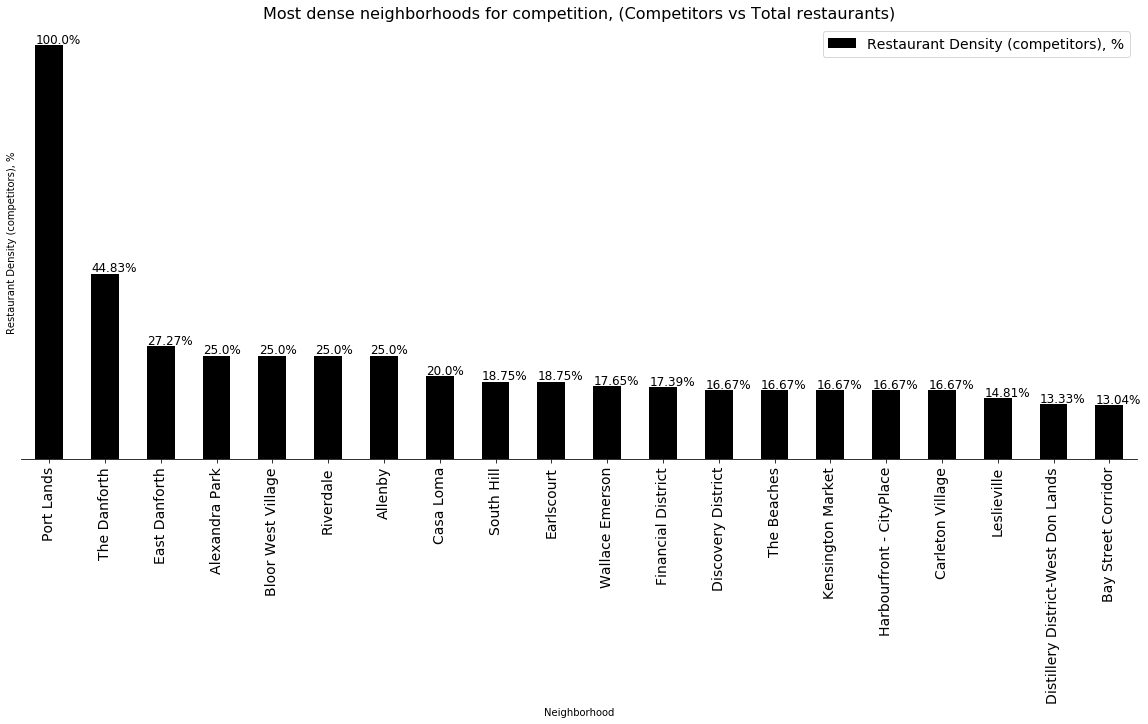

In [55]:
# Calculate factor1: Density of ethnic restaurants(same as language) out of total restaurants (less is best)

# Total number of restaurants and competitors
w1 = Toronto_restaurants_conclude[['Neighborhood','Language','Total Restaurants','Number of Competitors']].copy()

# Density of ethnic restaurants(same as language) out of total restaurants (less is best)
rd1 =  ((w1['Number of Competitors'] + 1) / w1['Total Restaurants']) * 100
w1['Restaurant Density (competitors), %'] = (rd1.astype(float)).round(2)

w1 = w1[['Neighborhood','Restaurant Density (competitors), %']].copy()
w1 =w1.sort_values('Restaurant Density (competitors), %',ascending=False).reset_index(drop=True)
top20_dense_restaurants = w1.head(20)

# Find the 20 more dense neighborhoods in terms of ethnic restaurants 
#top20_dense_restaurants
#w1.head(20)
top20_dense_restaurants


# Plot
ax = top20_dense_restaurants.plot(kind='bar', figsize=(20, 8), width=0.5, color=['black','green'])

ax.set_xlabel('Neighborhood')
ax.set_ylabel('Restaurant Density (competitors), %')

ax.set_title("Most dense neighborhoods for competition, (Competitors vs Total restaurants)",fontsize=16) # add title to the plot

ax.legend(fontsize=14)
ax.tick_params(labelsize=14)

ax.tick_params(left=False)
ax.tick_params(labelleft=False)

ax.set_xticklabels(top20_dense_restaurants['Neighborhood'])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in ax.patches: 
    ax.text(i.get_x()+0.01, i.get_height()+0.5, str(i.get_height())+'%', fontsize=12)

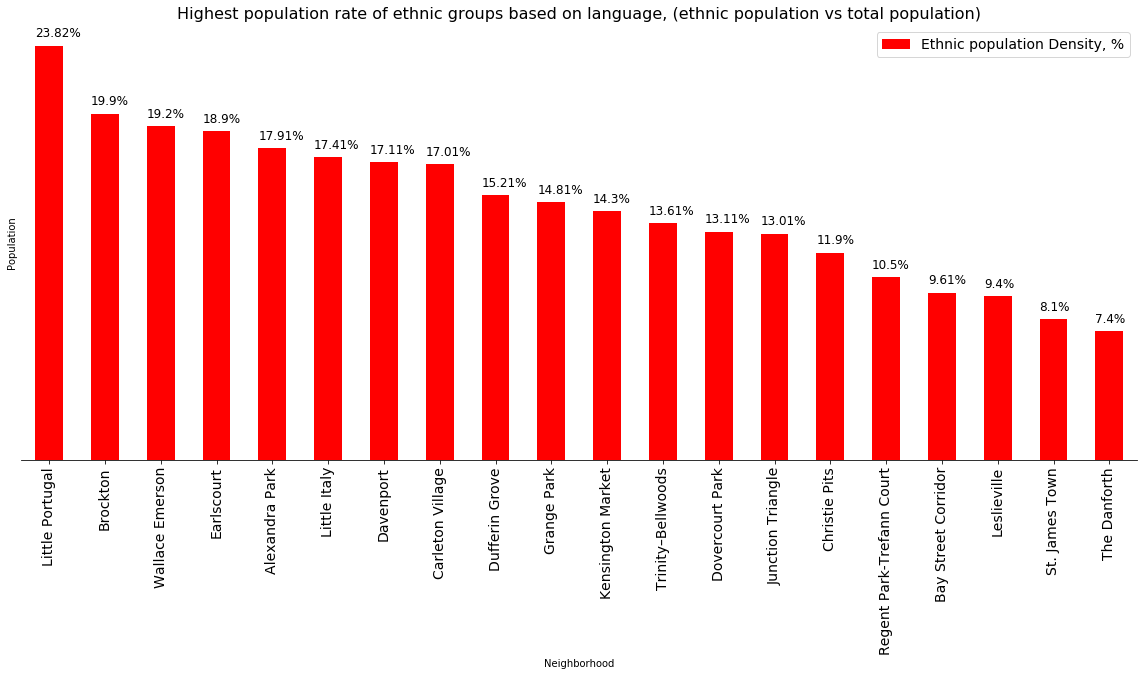

In [58]:
# Calculate factor2: Find the 20 more dense neighborhoods in terms of ethnic restaurants 

# Total number of population and ethnic minority speaking the 2nd most common language
w2 = Toronto_restaurants_conclude[['Neighborhood','Language','Population','Second language population']].copy()

# Density of ethnic population out of total population (less is best)
pd1 =  ((w2['Second language population'] + 1) / w2['Population']) * 100
w2['Ethnic population Density, %'] = (pd1.astype(float)).round(2)

w2 = w2[['Neighborhood','Ethnic population Density, %']].copy()
w2 = w2.sort_values('Ethnic population Density, %',ascending=False).reset_index(drop=True)
top20_dense_population = w2.head(20)
#top20_dense_population
#w2
top20_dense_population


# Plot
ax = top20_dense_population.plot(kind='bar', figsize=(20, 8), width=0.5, color=['red','blue'])

ax.set_xlabel('Neighborhood')
ax.set_ylabel('Population')

ax.set_title("Highest population rate of ethnic groups based on language, (ethnic population vs total population)",fontsize=16) # add title to the plot

ax.legend(fontsize=14)
ax.tick_params(labelsize=14)

ax.tick_params(left=False)
ax.tick_params(labelleft=False)

ax.set_xticklabels(top20_dense_population['Neighborhood'])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in ax.patches: 
    ax.text(i.get_x(), i.get_height()+0.5, str(i.get_height())+'%', fontsize=12)


In [29]:
# Add the density factors to main dataframe
T1 = Toronto_restaurants_conclude.copy()
T1.head()

T1 = pd.merge(T1,w1, on='Neighborhood', how='inner')
T2 = pd.merge(T1,w2, on='Neighborhood', how='inner')
Toronto_restaurants_final = T2.copy()
Toronto_restaurants_final = Toronto_restaurants_final.sort_values(by='Second language population',ascending=False).reset_index(drop=True)
Toronto_restaurants_final.head(10)

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %"
0,Earlscourt,Portuguese,17240,3258,16,2,43.678000,-79.449000,18.75,18.90
1,Leslieville,Cantonese,23567,2215,27,3,43.661927,-79.332039,14.81,9.40
2,Riverdale,Cantonese,31007,2077,28,6,43.667750,-79.349610,25.00,6.70
3,Wallace Emerson,Portuguese,10338,1984,17,2,43.663000,-79.441000,17.65,19.20
4,Brockton,Portuguese,9039,1798,32,0,43.660550,-79.405310,3.12,19.90
5,Davenport,Portuguese,8781,1501,19,1,43.673000,-79.428000,10.53,17.11
6,Dufferin Grove,Portuguese,9875,1501,28,1,43.657000,-79.428000,7.14,15.21
7,Little Italy,Portuguese,7917,1377,30,1,43.655000,-79.413000,6.67,17.41
8,Grange Park,Chinese,9007,1333,25,1,43.653000,-79.393000,8.00,14.81
9,Little Portugal,Portuguese,5013,1193,23,1,43.650000,-79.435556,8.70,23.82


In [30]:
# Save the final results
Toronto_restaurants_final.to_csv('Toronto_restaurants_final.csv')

# Clustering


In [31]:
# Manually try to find the optimum neighborhood:
# 1) Assume middle-class and above neighborhoods only
# 2) Large population, so to attract as many people as possible
# 3) Large ethnic community, so to have significant cultural characteristics
# 4) Less number of competitors, so to avoid competition as much as possible

T0 = Toronto_restaurants_final.copy()

# 1) Assume above middle-class and upper-class neihborhoods only
income=Toronto[['Neighborhood','Average income']]
Tx = pd.merge(T0, income, how='inner')
Toronto_restaurants_final_income = Tx.copy()

T0 = Tx[Tx['Average income'] > Tx['Average income'].mean()]
Toronto_restaurants_final_income = Tx.copy()

# 2) Large population, so to attract as many people as possible
T1 = T0[T0['Population'] > T0['Population'].mean()]

# 3) Large number of secondary population, i.e. significant ethnic community
T2 = T1[T1['Second language population'] > T0['Second language population'].mean()]

# 4) Less competitors possible
T3 = T2[T2['Restaurant Density (competitors), %'] < T0['Restaurant Density (competitors), %'].mean()]

T_manual = T3.sort_values(by='Restaurant Density (competitors), %')
T_manual

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income
27,Davisville,Persian,23727,355,35,0,43.701000,-79.389000,2.86,1.5,55735
35,The Annex,Spanish,15602,202,35,0,43.670000,-79.404000,2.86,1.3,63636
38,Deer Park,Russian,15165,166,17,0,43.688056,-79.394028,5.88,1.1,80704
28,Swansea,Polish,11133,333,15,0,43.643889,-79.477778,6.67,3.0,58681
22,Forest Hill,Russian,24056,577,13,0,43.700000,-79.416667,7.69,2.4,101631


In [32]:
T = Toronto_restaurants_final_income.copy()
T.head()

# set number of clusters
kclusters = 5

T_cluster = T.drop(['Neighborhood','Language'],axis=1)
#T_cluster = T.drop(['Neighborhood','Language','Population','Second language population'],axis=1)
T_cluster.head()

# run k-means clustering
k_means_cat = KMeans(n_clusters=kclusters, random_state=0).fit(T_cluster)

# check cluster labels generated for each row in the dataframe
k_means_cat.labels_[0:10]

#toronto_grouped_clustering_cat
labels_cat = k_means_cat.labels_
# add clustering labels
labels_cat

# Add cluster labels to main dataframe
T['Cluster Labels'] = labels_cat
Toronto_restaurants_final_income_coords = T.copy()
Toronto_restaurants_final_income_coords.head(10)

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Earlscourt,Portuguese,17240,3258,16,2,43.678000,-79.449000,18.75,18.90,26672,3
1,Leslieville,Cantonese,23567,2215,27,3,43.661927,-79.332039,14.81,9.40,30886,3
2,Riverdale,Cantonese,31007,2077,28,6,43.667750,-79.349610,25.00,6.70,40139,1
3,Wallace Emerson,Portuguese,10338,1984,17,2,43.663000,-79.441000,17.65,19.20,25029,3
4,Brockton,Portuguese,9039,1798,32,0,43.660550,-79.405310,3.12,19.90,27260,3
5,Davenport,Portuguese,8781,1501,19,1,43.673000,-79.428000,10.53,17.11,28335,3
6,Dufferin Grove,Portuguese,9875,1501,28,1,43.657000,-79.428000,7.14,15.21,27961,3
7,Little Italy,Portuguese,7917,1377,30,1,43.655000,-79.413000,6.67,17.41,31231,3
8,Grange Park,Chinese,9007,1333,25,1,43.653000,-79.393000,8.00,14.81,35277,3
9,Little Portugal,Portuguese,5013,1193,23,1,43.650000,-79.435556,8.70,23.82,29224,3


In [33]:
Cluster0 = Toronto_restaurants_final_income_coords.loc[Toronto_restaurants_final_income_coords['Cluster Labels'] == 0]
Cluster0 = Cluster0.sort_values(by='Restaurant Density (competitors), %').reset_index(drop=True)
Cluster0.head(10)
# Middle and upper-level, ethnic population is small, except The Annex 

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,The Annex,Spanish,15602,202,35,0,43.670000,-79.404000,2.86,1.30,63636,0
1,Fashion District,Portuguese,4642,51,33,0,43.645000,-79.398000,3.03,1.12,63282,0
2,Summerhill,Chinese,5100,56,27,0,43.683000,-79.390000,3.70,1.12,88937,0
3,Deer Park,Russian,15165,166,17,0,43.688056,-79.394028,5.88,1.10,80704,0
4,Chaplin Estates,French,4906,58,33,1,43.700000,-79.400000,6.06,1.20,81288,0
5,Bedford Park,Greek,13749,96,18,1,43.731380,-79.421160,11.11,0.71,80827,0
6,The Beaches,Cantonese,20416,142,12,1,43.667266,-79.297128,16.67,0.70,67536,0
7,Financial District,Japanese,548,9,23,3,43.647935,-79.381752,17.39,1.82,63952,0
8,Casa Loma,Korean,3597,64,40,7,43.670000,-79.410000,20.00,1.81,82203,0


In [34]:
Cluster1 = Toronto_restaurants_final_income_coords.loc[Toronto_restaurants_final_income_coords['Cluster Labels'] == 1]
Cluster1 = Cluster1.sort_values(by='Restaurant Density (competitors), %').reset_index(drop=True)
Cluster1
# High-class, Small ethnic group

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Seaton Village,Portuguese,5259,262,36,0,43.668000,-79.416000,2.78,5.00,41506,1
1,Davisville,Persian,23727,355,35,0,43.701000,-79.389000,2.86,1.50,55735,1
2,Harbord Village,Portuguese,5906,242,32,0,43.661000,-79.406000,3.12,4.11,45792,1
3,Playter Estates,Chinese,3968,71,30,0,43.678056,-79.355556,3.33,1.81,44557,1
4,Bracondale Hill,Greek,5343,256,28,0,43.676000,-79.428030,3.57,4.81,41605,1
5,Niagara,Portuguese,6524,260,25,0,43.643000,-79.408000,4.00,4.00,44611,1
6,Upper Beaches,Cantonese,19830,138,25,0,43.646667,-79.408333,4.00,0.70,44346,1
7,Roncesvalles,Polish,15996,703,23,0,43.646231,-79.449048,4.35,4.40,46820,1
8,High Park North,Polish,22746,682,18,0,43.656000,-79.475000,5.56,3.00,46437,1
9,Swansea,Polish,11133,333,15,0,43.643889,-79.477778,6.67,3.00,58681,1


In [35]:
Cluster2 = Toronto_restaurants_final_income_coords.loc[Toronto_restaurants_final_income_coords['Cluster Labels'] == 2]
Cluster2 = Cluster2.sort_values(by='Restaurant Density (competitors), %').reset_index(drop=True)
Cluster2
# Middle-class (<50K), Davisville(Persian) is good choice with high population, small restaurant density and ethnic-group big enough.

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Rosedale,Chinese,7672,76,23,0,43.646231,-79.449048,4.35,1.00,213941,2
1,Allenby,Russian,2513,35,4,0,43.712750,-79.547460,25.00,1.43,245592,2


In [36]:
Cluster3 = Toronto_restaurants_final_income_coords.loc[Toronto_restaurants_final_income_coords['Cluster Labels'] == 3]
Cluster3 = Cluster3.sort_values(by='Restaurant Density (competitors), %').reset_index(drop=True)
Cluster3
# Upper-class (>100K), although high restaurant density, small ethnic groups, except Forest Hill

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Christie Pits,Portuguese,5124,609,37,0,43.664722,-79.420833,2.70,11.90,30556,3
1,Brockton,Portuguese,9039,1798,32,0,43.660550,-79.405310,3.12,19.90,27260,3
2,Church and Wellesley,Spanish,13397,241,30,0,43.665694,-79.380956,3.33,1.81,37653,3
3,Regal Heights,Spanish,2719,149,30,0,43.676200,-79.424400,3.33,5.52,36652,3
4,Parkdale,Polish,28367,822,27,0,43.640454,-79.436731,3.70,2.90,26314,3
5,Garden District,Chinese,8240,247,26,0,43.658500,-79.375800,3.85,3.01,37614,3
6,Trinity–Bellwoods,Portuguese,8687,1181,25,0,43.646667,-79.408333,4.00,13.61,31106,3
7,Dovercourt Park,Portuguese,8497,1113,20,0,43.665000,-79.432000,5.00,13.11,28311,3
8,The Junction,Portuguese,11391,467,20,0,43.665556,-79.464444,5.00,4.11,34906,3
9,Little Italy,Portuguese,7917,1377,30,1,43.655000,-79.413000,6.67,17.41,31231,3


In [37]:
Cluster4 = Toronto_restaurants_final_income_coords.loc[Toronto_restaurants_final_income_coords['Cluster Labels'] == 4]
Cluster4 = Cluster4.sort_values(by='Restaurant Density (competitors), %').reset_index(drop=True)
Cluster4
# Low and middle-class

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Forest Hill,Russian,24056,577,13,0,43.700000,-79.416667,7.69,2.40,101631,4
1,Yorkville,French,6045,114,36,2,43.670278,-79.391111,8.33,1.90,105239,4
2,Lytton Park,Serbian,6494,58,8,0,43.716000,-79.406000,12.50,0.91,127356,4
3,South Hill,French,6218,62,16,2,43.681000,-79.404000,18.75,1.01,120453,4


In [40]:
# Visualize the neighborhoods per cluster. 

map_Toronto_clusters = folium.Map(location=[43.653963, -79.387207], zoom_start=13,  tiles = "Stamen Toner")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]

# Use different colors for each language
clrs =['red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
       'darkpurple', 'lightred', 'yellow', 'lightblue', 'lightgreen','gray', 'black']

cluster_name = Toronto_restaurants_final_income_coords['Cluster Labels'].unique()

CLR = dict(zip(cluster_name,clrs))

# add markers to the map
markers_colors = []
for lat, lon, poi, lang, cluster in zip(Toronto_restaurants_final_income_coords['Latitude'], 
                                      Toronto_restaurants_final_income_coords['Longitude'], 
                                      Toronto_restaurants_final_income_coords['Neighborhood'],
                                      Toronto_restaurants_final_income_coords['Language'],
                                      Toronto_restaurants_final_income_coords['Cluster Labels']):
    
    #print(poi,lat,lon)
    
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    label = folium.Popup('Cluster:{}, {}({})'.format(cluster,poi,lang),parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=(CLR[cluster]),
        fill=True,
        fill_color=(CLR[cluster]),
        fill_opacity=0.7).add_to(map_Toronto_clusters)
       
map_Toronto_clusters

In [41]:
Cluster2_final = Cluster2[Cluster2['Population'] > Cluster2['Population'].mean()]
Cluster2_final = Cluster2_final.sort_values(by='Ethnic population Density, %')
Cluster2_final

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Rosedale,Chinese,7672,76,23,0,43.646231,-79.449048,4.35,1.0,213941,2


In [42]:
# The best candidates from all clusters
a = ['Parkdale','Forest Hill','Davisville']
df = Toronto_restaurants_final_income_coords[Toronto_restaurants_final_income_coords.Neighborhood.isin(a)]
df.sort_values(by='Average income').reset_index(drop=True)

,Neighborhood,Language,Population,Second language population,Total Restaurants,Number of Competitors,Latitude,Longitude,"Restaurant Density (competitors), %","Ethnic population Density, %",Average income,Cluster Labels
0,Parkdale,Polish,28367,822,27,0,43.640454,-79.436731,3.70,2.9,26314,3
1,Davisville,Persian,23727,355,35,0,43.701000,-79.389000,2.86,1.5,55735,1
2,Forest Hill,Russian,24056,577,13,0,43.700000,-79.416667,7.69,2.4,101631,4


In [50]:
# Competitors
map_Toronto = folium.Map(location=[43.653963, -79.387207], zoom_start=13, tiles ='Stamen Toner')

def Create_map_competitors (df_coordinates, center_of_map):
    # Use different colors for each language
    clrs =['red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
           'darkpurple', 'lightred', 'yellow', 'lightblue', 'lightgreen','gray', 'black']

    lang = df_coordinates['Language'].unique()

    CLR = dict(zip(lang,clrs))

    # add markers to map
    for vlat, vlong, nb, lang, vcat in zip(
        df_coordinates['Venue Latitude'], 
        df_coordinates['Venue Longitude'], 
        df_coordinates['Neighborhood'],
        df_coordinates['Language'],
        df_coordinates['Venue Category']):
       
        label = folium.Popup('{}({}), {}'.format(nb,lang,vcat),parse_html=True)
        folium.Marker(
            location=[vlat,vlong],
            popup= label,
            icon=folium.Icon(CLR[lang])
        ).add_to(center_of_map) 

# Visualize the competition for Cluster 2 neighborhoods
Cluster2_comptetitors = pd.merge(Cluster2_final, Toronto_restaurants_coord_lang, how='inner')

Create_map_competitors(Cluster2_comptetitors, map_Toronto)

map_Toronto

# Conclusion

_The best neighborhood to open an ethnic restaurant is_

## "Davisville"

with 

## Persian
theme

In [52]:
# Visualise the competitor restaurants in Davisville

star = Cluster3.loc[Cluster3['Neighborhood'] == 'Davisville']
star_coords = pd.merge(star, Toronto_restaurants_coord_lang, how='inner')

# Use different colors for each venue category type
vcatlist = star_coords['Venue Category'].unique()
clrs =['red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
           'darkpurple', 'lightred', 'yellow', 'lightblue', 'lightgreen','gray', 'black', 'beige']
CLR = dict(zip(vcatlist,clrs))

map_star_competitors = folium.Map(location=[43.701, -79.389], zoom_start=15, tiles ='Stamen Toner')

def Create_map_competitors (df_coordinates, center_of_map):

    # add markers to map
    for vlat, vlong, nb, lang, vname, vcat in zip(
        df_coordinates['Venue Latitude'], 
        df_coordinates['Venue Longitude'], 
        df_coordinates['Neighborhood'],
        df_coordinates['Language'],
        df_coordinates['Venue'],
        df_coordinates['Venue Category']):
       
        label = folium.Popup('{} ({} language), "{}" - {}'.format(nb,lang,vname,vcat),parse_html=True)
        folium.Marker(
            location=[vlat,vlong],
            popup= label,
            icon=folium.Icon(CLR[vcat])
        ).add_to(center_of_map) 


Create_map_competitors(star_coords, map_star_competitors)

map_star_competitors